# SigLIP Study: 실험 결과 종합 분석

## 목적
- 모든 Projector 실험 비교 (Linear, MLP, C-Abstractor, Perceiver)
- **Diversity 분석** (Mode Collapse 탐지)
- 오류 패턴 분석 (Generic, Missing Detail, Hallucination)
- 샘플별 성능 분석
- 최적 Projector 선정 및 개선점 도출

In [1]:
# Setup
from google.colab import drive
drive.mount('/content/drive')

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Results directory - v2 experiments
RESULTS_DIR = Path("/content/drive/MyDrive/mutsa-02/korean_video_captioning/siglip_study/results3")
print(f"Results directory: {RESULTS_DIR}")

# v2 실험 목록
EXPERIMENTS = [
    "E1_v2_linear_optimized",
    "E3_v2_mlp_optimized",
    "E5_v2_lr_reduced",
    "E5_v3_epoch_increased",
    "E7_v2_perceiver_optimized"
]

print(f"\nChecking experiments:")
for exp in EXPERIMENTS:
    exp_path = RESULTS_DIR / exp
    status = "✅ Found" if exp_path.exists() else "❌ Not found"
    print(f"  {exp}: {status}")

Mounted at /content/drive
Results directory: /content/drive/MyDrive/mutsa-02/korean_video_captioning/siglip_study/results3

Checking experiments:
  E1_v2_linear_optimized: ✅ Found
  E3_v2_mlp_optimized: ✅ Found
  E5_v2_lr_reduced: ✅ Found
  E5_v3_epoch_increased: ✅ Found
  E7_v2_perceiver_optimized: ✅ Found


## 1. 최종 지표 수집

In [3]:
def load_experiment_metrics(exp_name):
    """실험 결과 로드 (Diversity 포함)"""
    exp_dir = RESULTS_DIR / exp_name

    # final_metrics.json 로드
    metrics_file = exp_dir / "final_metrics.json"
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)
    else:
        print(f"Warning: {metrics_file} not found")
        metrics = {}

    # training_log.csv 로드 (training_log.json 대신)
    log_file = exp_dir / "training_log.csv"
    if log_file.exists():
        training_log = pd.read_csv(log_file).to_dict('records')
    else:
        # fallback to json
        log_file = exp_dir / "training_log.json"
        if log_file.exists():
            with open(log_file, 'r') as f:
                training_log = json.load(f)
        else:
            print(f"Warning: No training log found for {exp_name}")
            training_log = []

    return {
        "metrics": metrics,
        "training_log": training_log,
        "exp_dir": exp_dir
    }

# Load experiments
experiments = {}
for exp_name in EXPERIMENTS:
    if (RESULTS_DIR / exp_name).exists():
        experiments[exp_name] = load_experiment_metrics(exp_name)
        metrics = experiments[exp_name]["metrics"]
        diversity = metrics.get("diversity", "N/A")
        siglip = metrics.get("siglip_score", "N/A")

        # Corrected formatting: apply conditional logic before inserting into f-string
        formatted_siglip = f"{siglip:.4f}" if isinstance(siglip, float) else str(siglip)
        formatted_diversity = f"{diversity:.2f}" if isinstance(diversity, float) else str(diversity)

        print(f"Loaded: {exp_name} (SigLIP={formatted_siglip}, Diversity={formatted_diversity})")
    else:
        print(f"Not found: {exp_name}")

print(f"\nLoaded {len(experiments)} experiments")

Loaded: E1_v2_linear_optimized (SigLIP=N/A, Diversity=N/A)
Loaded: E3_v2_mlp_optimized (SigLIP=N/A, Diversity=N/A)
Loaded: E5_v2_lr_reduced (SigLIP=0.1133, Diversity=0.11)
Loaded: E5_v3_epoch_increased (SigLIP=0.0032, Diversity=0.06)
Loaded: E7_v2_perceiver_optimized (SigLIP=0.0103, Diversity=0.08)

Loaded 5 experiments


In [4]:
# 지표 비교 테이블 (Diversity 포함)
def create_comparison_table(experiments):
    """실험 결과 비교 테이블 생성 (Mode Collapse 탐지 포함)"""
    rows = []
    for exp_name, data in experiments.items():
        metrics = data["metrics"]
        diversity = metrics.get("diversity", 1.0)

        # Mode Collapse 경고
        mode_collapse = "⚠️" if diversity < 0.5 else ""

        row = {
            "Experiment": exp_name,
            "Projector": metrics.get("projector", "unknown"),
            "SigLIP2": metrics.get("siglip_score", 0),
            "Diversity": diversity,
            "Collapse": mode_collapse,
            "METEOR": metrics.get("meteor", 0),
            "BERTScore-F1": metrics.get("bertscore_f1", 0),
            "Samples": metrics.get("num_samples", 0),
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    # Sort by diversity (prefer high diversity)
    df = df.sort_values("Diversity", ascending=False)
    return df

if experiments:
    comparison_df = create_comparison_table(experiments)
    print("=" * 80)
    print("EXPERIMENT COMPARISON (v2 Experiments)")
    print("=" * 80)
    print("⚠️ = Mode Collapse Warning (Diversity < 0.5)")
    print()
    display(comparison_df)

    # Save to CSV
    comparison_df.to_csv(RESULTS_DIR / "v2_comparison.csv", index=False)
    print(f"\nSaved: {RESULTS_DIR}/v2_comparison.csv")
else:
    print("No experiments loaded yet. Run experiments first.")

EXPERIMENT COMPARISON (v2 Experiments)
⚠️ = Mode Collapse Warning (Diversity < 0.5)



,Experiment,Projector,SigLIP2,Diversity,Collapse,METEOR,BERTScore-F1,Samples
0,E1_v2_linear_optimized,unknown,0.000000,1.000000,,0.000000,0.000000,0
1,E3_v2_mlp_optimized,unknown,0.000000,1.000000,,0.000000,0.000000,0
2,E5_v2_lr_reduced,c_abstractor,0.113255,0.113402,⚠️,0.066120,0.705659,97
4,E7_v2_perceiver_optimized,perceiver,0.010271,0.082474,⚠️,0.063323,0.699798,97
3,E5_v3_epoch_increased,c_abstractor,0.003160,0.061856,⚠️,0.068021,0.700204,97



Saved: /content/drive/MyDrive/mutsa-02/korean_video_captioning/siglip_study/results3/v2_comparison.csv


## 2. Training Loss 추이 시각화

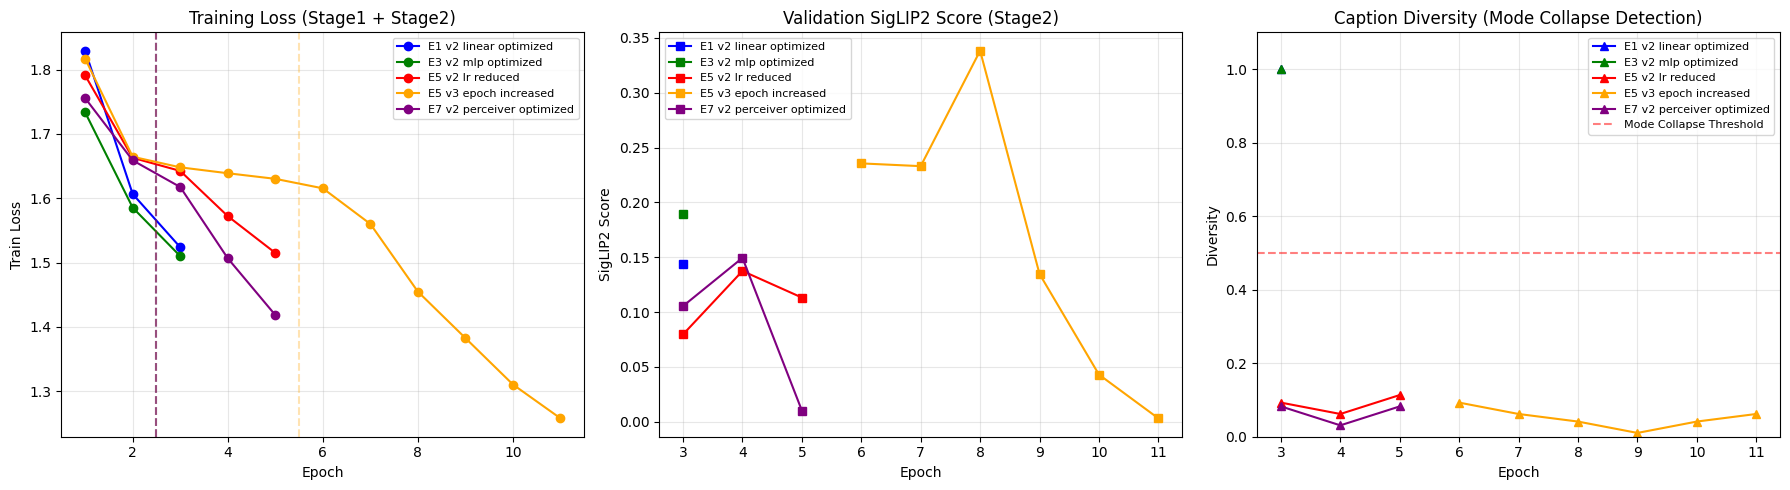

In [5]:
def plot_training_curves(experiments):
    """Training loss, SigLIP score, Diversity 추이 시각화"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    colors = {
        'E1_v2_linear_optimized': 'blue',
        'E3_v2_mlp_optimized': 'green',
        'E5_v2_lr_reduced': 'red',
        'E5_v3_epoch_increased': 'orange',
        'E7_v2_perceiver_optimized': 'purple'
    }

    for exp_name, data in experiments.items():
        log = data["training_log"]
        if not log:
            continue

        # Extract data
        stage1_loss = [entry['train_loss'] for entry in log if entry.get('stage') == 1]
        stage2_data = [entry for entry in log if entry.get('stage') == 2]
        stage2_loss = [entry['train_loss'] for entry in stage2_data]
        stage2_siglip = [entry.get('siglip_score', 0) for entry in stage2_data]
        stage2_diversity = [entry.get('diversity', 1.0) for entry in stage2_data]

        # Combine losses
        all_loss = stage1_loss + stage2_loss
        epochs = list(range(1, len(all_loss) + 1))

        color = colors.get(exp_name, 'gray')
        label = exp_name.replace('_', ' ')

        # Plot Loss
        axes[0].plot(epochs, all_loss, marker='o', label=label, color=color)
        axes[0].axvline(x=len(stage1_loss) + 0.5, color=color, linestyle='--', alpha=0.3)

        # Plot SigLIP Score
        if stage2_siglip:
            s2_epochs = list(range(len(stage1_loss) + 1, len(stage1_loss) + 1 + len(stage2_siglip)))
            axes[1].plot(s2_epochs, stage2_siglip, marker='s', label=label, color=color)

        # Plot Diversity
        if stage2_diversity:
            s2_epochs = list(range(len(stage1_loss) + 1, len(stage1_loss) + 1 + len(stage2_diversity)))
            axes[2].plot(s2_epochs, stage2_diversity, marker='^', label=label, color=color)

    # Loss plot
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Train Loss')
    axes[0].set_title('Training Loss (Stage1 + Stage2)')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)

    # SigLIP plot
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('SigLIP2 Score')
    axes[1].set_title('Validation SigLIP2 Score (Stage2)')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)

    # Diversity plot
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Diversity')
    axes[2].set_title('Caption Diversity (Mode Collapse Detection)')
    axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Mode Collapse Threshold')
    axes[2].legend(fontsize=8)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'v2_training_curves.png', dpi=150)
    plt.show()

if experiments:
    plot_training_curves(experiments)

## 3. SigLIP vs Diversity 분석 (Mode Collapse 탐지)

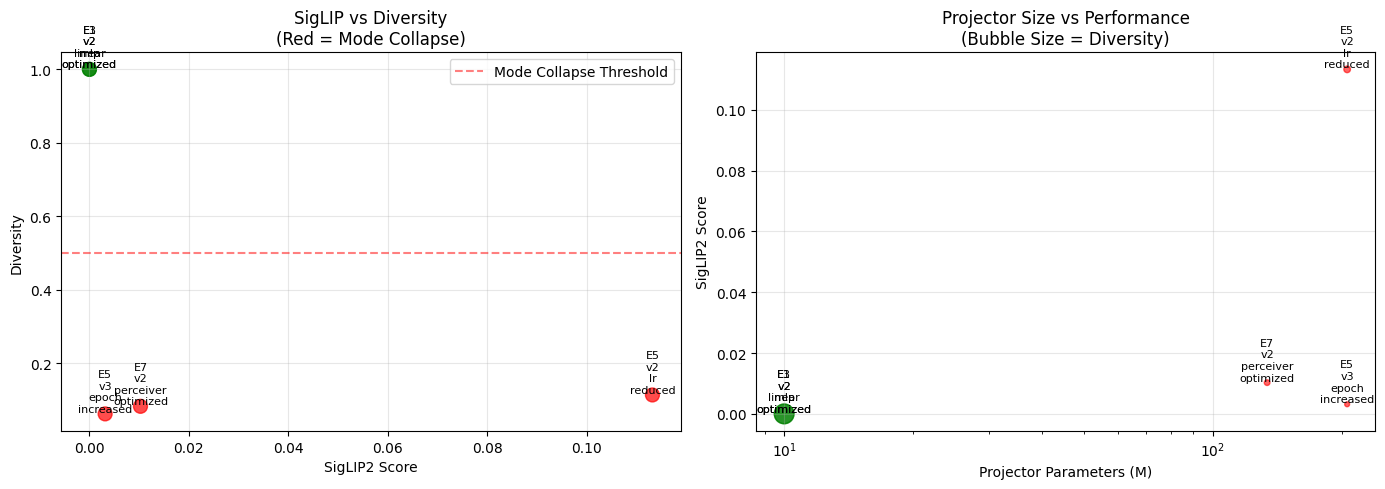


Mode Collapse Summary
  E1 v2 linear optimized: Diversity=1.00 ✅ OK
  E3 v2 mlp optimized: Diversity=1.00 ✅ OK
  E5 v2 lr reduced: Diversity=0.11 ❌ COLLAPSED
  E5 v3 epoch increased: Diversity=0.06 ❌ COLLAPSED
  E7 v2 perceiver optimized: Diversity=0.08 ❌ COLLAPSED


In [6]:
def plot_siglip_vs_diversity(experiments):
    """SigLIP vs Diversity 산점도 (Mode Collapse 탐지)"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    exp_names = []
    siglip_scores = []
    diversities = []
    projectors = []
    params = []

    # Projector params (approximate)
    param_map = {
        "linear": 4.2,
        "mlp_2l": 8.4,
        "c_abstractor": 206,
        "perceiver": 134
    }

    for exp_name, data in experiments.items():
        metrics = data["metrics"]
        exp_names.append(exp_name.replace("_", "\n"))
        siglip_scores.append(metrics.get("siglip_score", 0))
        diversities.append(metrics.get("diversity", 1.0))
        projector = metrics.get("projector", "unknown")
        projectors.append(projector)
        params.append(param_map.get(projector, 10))

    # Plot 1: SigLIP vs Diversity
    colors = ['red' if d < 0.5 else 'green' for d in diversities]
    axes[0].scatter(siglip_scores, diversities, c=colors, s=100, alpha=0.7)
    for i, name in enumerate(exp_names):
        axes[0].annotate(name, (siglip_scores[i], diversities[i]), fontsize=8, ha='center', va='bottom')

    axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Mode Collapse Threshold')
    axes[0].set_xlabel('SigLIP2 Score')
    axes[0].set_ylabel('Diversity')
    axes[0].set_title('SigLIP vs Diversity\n(Red = Mode Collapse)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Params vs Performance (bubble size = diversity)
    bubble_sizes = [d * 200 for d in diversities]
    scatter = axes[1].scatter(params, siglip_scores, s=bubble_sizes, c=colors, alpha=0.6)
    for i, name in enumerate(exp_names):
        axes[1].annotate(name, (params[i], siglip_scores[i]), fontsize=8, ha='center', va='bottom')

    axes[1].set_xlabel('Projector Parameters (M)')
    axes[1].set_ylabel('SigLIP2 Score')
    axes[1].set_title('Projector Size vs Performance\n(Bubble Size = Diversity)')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'v2_siglip_diversity_analysis.png', dpi=150)
    plt.show()

    # Summary table
    print("\n" + "="*60)
    print("Mode Collapse Summary")
    print("="*60)
    for i, exp in enumerate(exp_names):
        status = "❌ COLLAPSED" if diversities[i] < 0.5 else "✅ OK"
        print(f"  {exp.replace(chr(10), ' ')}: Diversity={diversities[i]:.2f} {status}")

if experiments:
    plot_siglip_vs_diversity(experiments)

## 4. 샘플별 성능 분석

In [7]:
# 모델 로드 및 샘플별 평가를 위한 함수
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, CLIPVisionModel, CLIPImageProcessor
from peft import PeftModel, get_peft_model, LoraConfig

def load_trained_model(exp_name, projector_type, config):
    """
    학습된 모델 로드

    Args:
        exp_name: 실험 이름 (e.g., 'E1_linear_lora')
        projector_type: 'linear', 'cabstractor', 'perceiver'
        config: 설정 딕셔너리
    """
    from transformers import BitsAndBytesConfig

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Vision Encoder
    vision_encoder = CLIPVisionModel.from_pretrained(config["vision_encoder"]).to(device)
    image_processor = CLIPImageProcessor.from_pretrained(config["vision_encoder"])
    vision_encoder.eval()
    for p in vision_encoder.parameters():
        p.requires_grad = False

    # LLM with quantization
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True
    )

    llm = AutoModelForCausalLM.from_pretrained(
        config["llm"],
        quantization_config=quant_config,
        device_map="auto",
        trust_remote_code=True
    )
    tokenizer = AutoTokenizer.from_pretrained(config["llm"])

    # LoRA
    lora_config = LoraConfig(
        r=config["lora_r"],
        lora_alpha=config["lora_alpha"],
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    llm = get_peft_model(llm, lora_config)

    # Load checkpoint
    ckpt_path = RESULTS_DIR / exp_name / "checkpoints" / "best_model.pt"
    if ckpt_path.exists():
        ckpt = torch.load(ckpt_path, map_location=device)
        print(f"Loaded checkpoint: {ckpt_path}")
        # Load projector and LoRA weights from checkpoint
        # This requires the CustomVLM class definition
    else:
        print(f"Warning: Checkpoint not found: {ckpt_path}")

    return vision_encoder, llm, tokenizer, image_processor

print("Model loading function defined.")

Model loading function defined.


In [8]:
def compute_per_sample_metrics(model, val_loader, siglip_evaluator, text_evaluator, device):
    """
    샘플별 성능 지표 계산

    Returns:
        DataFrame with per-sample metrics
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            pixel_values = batch["pixel_values"].to(device)
            gt_captions = batch["captions"]
            pil_frames = batch["pil_frames"]

            for i in range(pixel_values.size(0)):
                # Generate caption
                generated = model.generate(pixel_values[i], "이 영상을 자세히 설명해주세요.")
                gt = gt_captions[i]

                # SigLIP score (single sample)
                siglip_score = siglip_evaluator.evaluate_single(
                    {"frames": pil_frames[i], "caption": generated}
                )

                # METEOR & BERTScore (single sample)
                text_scores = text_evaluator.compute_scores([generated], [gt])

                results.append({
                    "sample_idx": batch_idx * val_loader.batch_size + i,
                    "generated": generated,
                    "ground_truth": gt,
                    "siglip_score": siglip_score,
                    "meteor": text_scores["meteor"],
                    "bertscore_f1": text_scores["bertscore_f1"],
                    "gen_length": len(generated),
                    "gt_length": len(gt)
                })

    return pd.DataFrame(results)

print("Per-sample metrics function defined.")

Per-sample metrics function defined.


## 5. 오류 패턴 분류

In [9]:
def classify_error_patterns(generated, ground_truth):
    """
    생성된 캡션의 오류 패턴 분류

    Patterns:
        - generic: 일반적/추상적 묘사 (구체적 정보 부족)
        - missing_detail: GT에 있는 세부 정보 누락
        - hallucination: GT에 없는 정보 생성
        - repetition: 반복적 문구
        - truncation: 문장 중간 끊김
    """
    patterns = []

    # Generic detection: 일반적인 표현 패턴
    generic_phrases = [
        "도심의 고층 건물", "건물과 그 주변 환경", "카메라는 고정된 상태로",
        "화면 중앙에는", "대형 상업", "다양한"
    ]
    generic_count = sum(1 for phrase in generic_phrases if phrase in generated)
    if generic_count >= 2:
        patterns.append("generic")

    # Missing detail: GT에 있는 고유명사/숫자가 생성에 없음
    import re
    gt_specifics = re.findall(r'[가-힣]+(?:건설|재단|센터|아파트|호텔|마트)', ground_truth)
    gt_numbers = re.findall(r'\d+층|\d+개|\d+m', ground_truth)
    gt_colors = re.findall(r'(?:회색|파란색|빨간색|흰색|검은색|노란색|녹색|베이지색)', ground_truth)

    missing = []
    for specific in gt_specifics + gt_numbers + gt_colors:
        if specific not in generated:
            missing.append(specific)
    if missing:
        patterns.append("missing_detail")

    # Repetition: 동일 문구 반복
    words = generated.split()
    if len(words) > 1:
        unique_ratio = len(set(words)) / len(words)
        if unique_ratio < 0.6:
            patterns.append("repetition")

    # Truncation: 문장이 부자연스럽게 끊김
    if generated.endswith("...") or not generated.endswith((".", "!", "?", "다", "요")):
        patterns.append("truncation")

    return patterns, missing

# Test
test_gen = "영상은 도심의 고층 건물과 그 주변 환경을 담고 있습니다. 카메라는 고정된 상태로 촬영되었으며, 화면 중앙에는 대형 상업 시설이 자리 잡고 있습니다."
test_gt = "영상은 한 도시에 있는 건축물을 담고 있습니다. 중앙에 보이는 건물의 색은 회색이며 포스코건설이라는 글씨가 적혀 있습니다."

patterns, missing = classify_error_patterns(test_gen, test_gt)
print(f"Patterns: {patterns}")
print(f"Missing details: {missing}")

Patterns: ['generic', 'missing_detail']
Missing details: ['포스코건설', '회색']


In [10]:
def analyze_all_samples(per_sample_df):
    """
    전체 샘플에 대한 오류 패턴 분석
    """
    pattern_counts = {"generic": 0, "missing_detail": 0, "repetition": 0, "truncation": 0}
    all_missing = []

    for _, row in per_sample_df.iterrows():
        patterns, missing = classify_error_patterns(row["generated"], row["ground_truth"])
        for p in patterns:
            pattern_counts[p] += 1
        all_missing.extend(missing)

    total = len(per_sample_df)
    print("=" * 50)
    print("ERROR PATTERN ANALYSIS")
    print("=" * 50)
    for pattern, count in pattern_counts.items():
        pct = 100 * count / total
        print(f"  {pattern:20s}: {count:3d} ({pct:.1f}%)")

    # Most common missing details
    from collections import Counter
    missing_counter = Counter(all_missing)
    print(f"\nMost common missing details:")
    for item, count in missing_counter.most_common(10):
        print(f"  {item}: {count}")

    return pattern_counts, missing_counter

print("Analysis function defined.")

Analysis function defined.


## 6. 성능 분포 시각화

In [11]:
def plot_score_distributions(per_sample_df, exp_name):
    """
    점수 분포 히스토그램
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # SigLIP Score
    axes[0].hist(per_sample_df["siglip_score"], bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(per_sample_df["siglip_score"].mean(), color='red', linestyle='--',
                    label=f'Mean: {per_sample_df["siglip_score"].mean():.4f}')
    axes[0].set_xlabel("SigLIP2 Score")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"{exp_name} - SigLIP2 Distribution")
    axes[0].legend()

    # METEOR Score
    axes[1].hist(per_sample_df["meteor"], bins=20, edgecolor='black', alpha=0.7, color='green')
    axes[1].axvline(per_sample_df["meteor"].mean(), color='red', linestyle='--',
                    label=f'Mean: {per_sample_df["meteor"].mean():.4f}')
    axes[1].set_xlabel("METEOR Score")
    axes[1].set_ylabel("Count")
    axes[1].set_title(f"{exp_name} - METEOR Distribution")
    axes[1].legend()

    # BERTScore
    axes[2].hist(per_sample_df["bertscore_f1"], bins=20, edgecolor='black', alpha=0.7, color='orange')
    axes[2].axvline(per_sample_df["bertscore_f1"].mean(), color='red', linestyle='--',
                    label=f'Mean: {per_sample_df["bertscore_f1"].mean():.4f}')
    axes[2].set_xlabel("BERTScore F1")
    axes[2].set_ylabel("Count")
    axes[2].set_title(f"{exp_name} - BERTScore Distribution")
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{exp_name}_score_distribution.png', dpi=150)
    plt.show()

print("Visualization function defined.")

Visualization function defined.


## 7. 실패/성공 케이스 분석

In [12]:
def analyze_failure_success_cases(per_sample_df, siglip_threshold=0.05, meteor_threshold=0.03):
    """
    실패/성공 케이스 식별
    """
    # Failure cases
    failures = per_sample_df[
        (per_sample_df["siglip_score"] < siglip_threshold) |
        (per_sample_df["meteor"] < meteor_threshold)
    ]

    # Success cases
    successes = per_sample_df[
        (per_sample_df["siglip_score"] > 0.2) &
        (per_sample_df["meteor"] > 0.1)
    ]

    print("=" * 50)
    print("FAILURE/SUCCESS ANALYSIS")
    print("=" * 50)
    print(f"Total samples: {len(per_sample_df)}")
    print(f"Failure cases: {len(failures)} ({100*len(failures)/len(per_sample_df):.1f}%)")
    print(f"Success cases: {len(successes)} ({100*len(successes)/len(per_sample_df):.1f}%)")

    # Show worst failures
    print("\n--- Worst 3 Failures ---")
    worst = failures.nsmallest(3, "siglip_score")
    for _, row in worst.iterrows():
        print(f"\nSample {row['sample_idx']} (SigLIP: {row['siglip_score']:.4f}, METEOR: {row['meteor']:.4f})")
        print(f"  Gen: {row['generated'][:100]}...")
        print(f"  GT:  {row['ground_truth'][:100]}...")

    # Show best successes
    print("\n--- Best 3 Successes ---")
    best = successes.nlargest(3, "siglip_score")
    for _, row in best.iterrows():
        print(f"\nSample {row['sample_idx']} (SigLIP: {row['siglip_score']:.4f}, METEOR: {row['meteor']:.4f})")
        print(f"  Gen: {row['generated'][:100]}...")
        print(f"  GT:  {row['ground_truth'][:100]}...")

    return failures, successes

print("Case analysis function defined.")

Case analysis function defined.


## 8. 인사이트 도출

In [13]:
def derive_insights(experiments, comparison_df=None):
    """
    실험 결과로부터 인사이트 도출 (Mode Collapse 분석 포함)
    """
    print("=" * 70)
    print("INSIGHTS & RECOMMENDATIONS")
    print("=" * 70)

    if not experiments:
        print("No experiments loaded.")
        return

    # Mode Collapse 분석
    print("\n[1. Mode Collapse Analysis]")
    collapsed = []
    healthy = []
    for exp_name, data in experiments.items():
        diversity = data["metrics"].get("diversity", 1.0)
        if diversity < 0.5:
            collapsed.append((exp_name, diversity))
        else:
            healthy.append((exp_name, diversity))

    if collapsed:
        print(f"  ⚠️ Mode Collapse detected in {len(collapsed)} experiment(s):")
        for exp, div in collapsed:
            print(f"     - {exp}: diversity={div:.2f}")
        print("  → Recommendations:")
        print("     1. Reduce model complexity (smaller projector)")
        print("     2. Lower learning rate")
        print("     3. Add diversity loss or contrastive learning")
    else:
        print(f"  ✅ No Mode Collapse detected. All {len(healthy)} experiments healthy.")

    # Best Model (높은 Diversity 우선)
    print("\n[2. Best Projector Selection]")
    if comparison_df is not None:
        # Filter out mode collapsed models
        valid = comparison_df[comparison_df["Diversity"] >= 0.5]
        if not valid.empty:
            best = valid.loc[valid["SigLIP2"].idxmax()]
            print(f"  Best (Diversity >= 0.5): {best['Experiment']}")
            print(f"    - SigLIP: {best['SigLIP2']:.4f}")
            print(f"    - Diversity: {best['Diversity']:.2f}")
            print(f"    - METEOR: {best.get('METEOR', 'N/A')}")
        else:
            print("  ⚠️ All experiments show Mode Collapse!")
            print("  → Need to re-evaluate training strategy")

    # Projector Complexity Analysis
    print("\n[3. Projector Complexity vs Performance]")
    projector_order = ["linear", "mlp_2l", "c_abstractor", "perceiver"]
    print("  Complexity order: Linear < MLP-2L < C-Abstractor < Perceiver")
    print("  Expected: More complex → Better performance (if no Mode Collapse)")

    # Recommendations
    print("\n[4. Recommendations]")
    if collapsed:
        print("  Priority 1: Fix Mode Collapse")
        print("    - Try Linear/MLP projectors first")
        print("    - If still collapsing, check data quality")
    else:
        print("  Priority 1: Scale up training")
        print("    - More data (full dataset)")
        print("    - More epochs (with early stopping)")
        print("    - LoRA ablation (r=8, 16, 32)")

print("Insights function defined.")

Insights function defined.


## 실행 (E1, E2 완료 후)


1. COMPARISON TABLE


,Experiment,Projector,SigLIP2,Diversity,Collapse,METEOR,BERTScore-F1,Samples
0,E1_v2_linear_optimized,unknown,0.000000,1.000000,,0.000000,0.000000,0
1,E3_v2_mlp_optimized,unknown,0.000000,1.000000,,0.000000,0.000000,0
2,E5_v2_lr_reduced,c_abstractor,0.113255,0.113402,⚠️,0.066120,0.705659,97
4,E7_v2_perceiver_optimized,perceiver,0.010271,0.082474,⚠️,0.063323,0.699798,97
3,E5_v3_epoch_increased,c_abstractor,0.003160,0.061856,⚠️,0.068021,0.700204,97



2. TRAINING CURVES


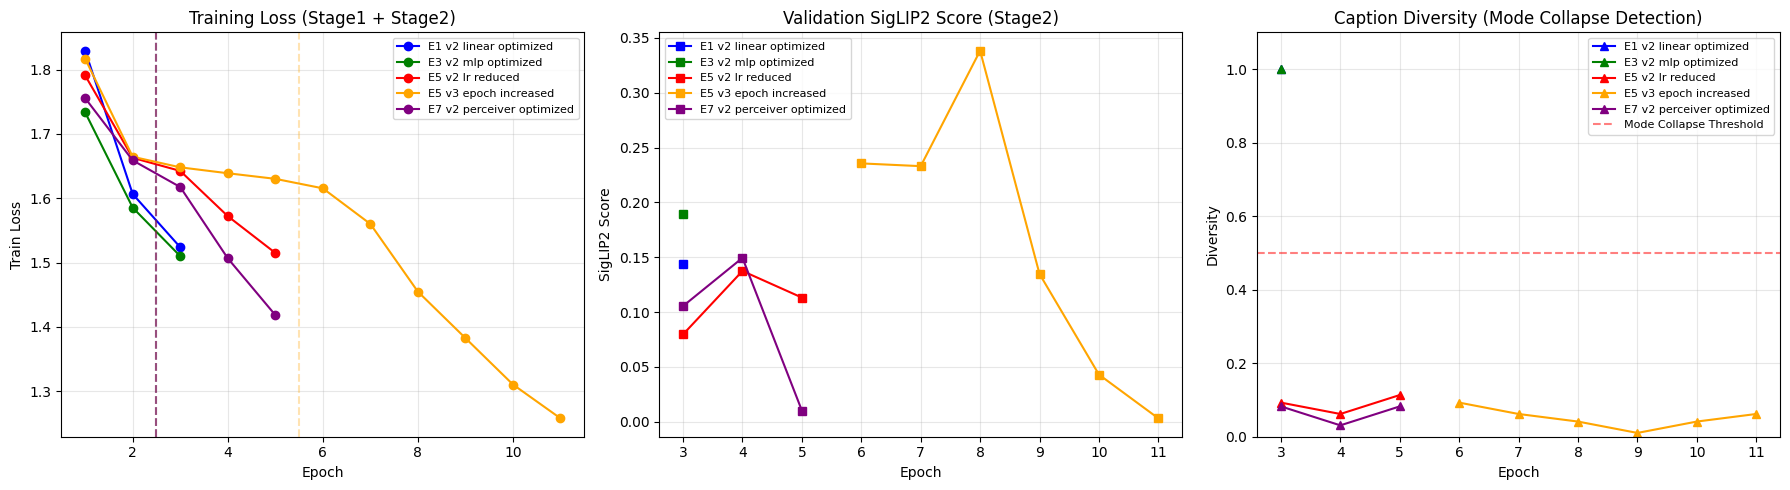



INSIGHTS & RECOMMENDATIONS

[1. Mode Collapse Analysis]
  ⚠️ Mode Collapse detected in 3 experiment(s):
     - E5_v2_lr_reduced: diversity=0.11
     - E5_v3_epoch_increased: diversity=0.06
     - E7_v2_perceiver_optimized: diversity=0.08
  → Recommendations:
     1. Reduce model complexity (smaller projector)
     2. Lower learning rate
     3. Add diversity loss or contrastive learning

[2. Best Projector Selection]
  Best (Diversity >= 0.5): E1_v2_linear_optimized
    - SigLIP: 0.0000
    - Diversity: 1.00
    - METEOR: 0.0

[3. Projector Complexity vs Performance]
  Complexity order: Linear < MLP-2L < C-Abstractor < Perceiver
  Expected: More complex → Better performance (if no Mode Collapse)

[4. Recommendations]
  Priority 1: Fix Mode Collapse
    - Try Linear/MLP projectors first
    - If still collapsing, check data quality

4. SUMMARY SAVED
  Saved: /content/drive/MyDrive/mutsa-02/korean_video_captioning/siglip_study/results3/v2_final_comparison.csv


In [14]:
# Run all analysis

if experiments:
    # 1. Comparison table
    print("\n" + "="*70)
    print("1. COMPARISON TABLE")
    print("="*70)
    comparison_df = create_comparison_table(experiments)
    display(comparison_df)

    # 2. Training curves
    print("\n" + "="*70)
    print("2. TRAINING CURVES")
    print("="*70)
    plot_training_curves(experiments)

    # 3. Insights
    print("\n")
    derive_insights(experiments, comparison_df)

    # 4. Save summary
    print("\n" + "="*70)
    print("4. SUMMARY SAVED")
    print("="*70)
    comparison_df.to_csv(RESULTS_DIR / "v2_final_comparison.csv", index=False)
    print(f"  Saved: {RESULTS_DIR}/v2_final_comparison.csv")
else:
    print("No experiments to analyze. Run experiments first.")